# Zuber - Riders Data Analysis

## Introduction
<a name="introduction"></a>

A database of users' riding behaviour have been provided for analysis. The dataset will be processed to avoid or minimise skewed analysis, exploratory data analysis will be conducted and hypotheses testing will be done in order to reach some conclusions. This report will consist of the following:

1. General information on the datasets
2. Data preprocessing stages, categorising data and adding other relevant variables
3. Exploratory data analysis on popular dropoff locations and taxi companies
4. Hypotheses testing to determine whether weather affects users' riding preference on certain day and location

The main goal of this report is to provide Zuber with passenger preferences and the impact of external factors on rides. The conclusions drawn in this report will also provide suggestions on which strategy best serves Zuber.

### Table of contents
1. [Introduction](#introduction)
2. [Data Preprocessing](#dpp)
3. [Exploratory Data Analysis](#eda)
4. [Hypotheses Testing](#hypo)
5. [Conclusion](#cons)

## General Information

In [27]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math as mt
from math import factorial
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the csv files
try:
    df_one = pd.read_csv('project_sql_result_01.csv')
    df_two = pd.read_csv('project_sql_result_04.csv')
    df_three = pd.read_csv('project_sql_result_07.csv')
except:
    df_one = pd.read_csv('/datasets/project_sql_result_01.csv')
    df_two = pd.read_csv('/datasets/project_sql_result_04.csv')
    df_three = pd.read_csv('/datasets/project_sql_result_07.csv')

In [30]:
# read chicago weather
URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

heading_table = [] 
for row in soup.find_all('th'):
    heading_table.append(row.text)

content = [] 
for row in soup.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

weather_records = pd.DataFrame(content, columns=heading_table)

In [3]:
def data_info(data):
    """This function helps simplify reading multiple datasets.
    
    This function takes the dataset variable as input and 
    produces the general information about each dataset, 
    including description, duplicates and missing values."""
    print('General dataset information:')
    print(data.info())
    print()
    print('First five rows:')
    print(data.head())
    print()
    print('Description of the dataset:')
    print(data.describe())
    print()
    print('This dataset has {} duplicates.'.format(data.duplicated().sum()))
    print()
    print('How many missing values does this data have?')
    print(data.isna().sum())
    print()
    print('What is the percentage of the missing values?')
    print(data.isna().sum() / len(data))

### First Dataframe Information and Processing

In [4]:
data_info(df_one)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None

First five rows:
                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299

Description of the dataset:
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000

This dataset has 0 duplicates.

How many missing values does this data have?
company_name    0
trips_amount    0
dtype: int6

The first dataset tells us about which taxi companies have the highest trips in November. The dataset does not have any missing values, duplicates, or incorrect data type. We can move forward with analysing the dataset.

### Second Dataframe Information and Processing

In [5]:
data_info(df_two)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

First five rows:
  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000

Description of the dataset:
       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667

This dataset has 0 duplicates.

How many missing values does this data have?
dropoff_location_name    0
average_trips            0
dt

The second dataset tells us about which dropoff location is the most popular in November. The dataset does not have any missing values or duplicates, but one of the column does not have the correct datatype, so we need to change it before we can move forward with analysing the dataset.

In [6]:
# change average trips into integer for ease of analysis
df_two['average_trips'] = df_two['average_trips'].astype(int)

## Exploratory Data Analysis
<a name="eda"></a>

### Top Neighbourhoods

In [7]:
df_two.sort_values('average_trips', ascending=False).head(10)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


In [8]:
popular_loc = df_two.nlargest(10, 'average_trips')

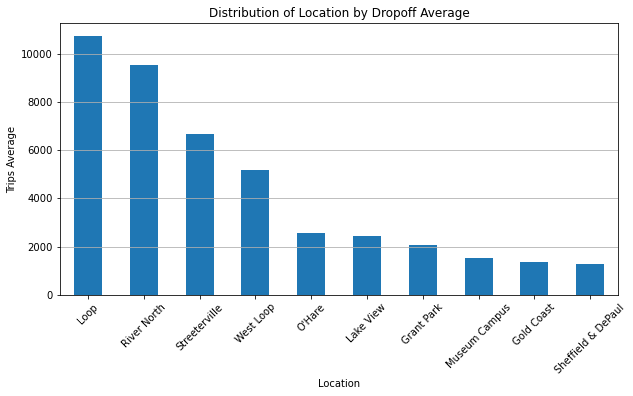

In [9]:
(popular_loc
     .groupby('dropoff_location_name')['average_trips']
     .mean()
     .sort_values(ascending=False)
     .plot(kind='bar', figsize=(10, 5))
)

plt.title('Distribution of Location by Dropoff Average')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylabel('Trips Average');

Based on the riders' data and as we can see in the bar chart, the top 4 destinations are all located in Downtown Chicago. The Loop, one of Chicago's 77 designated community areas, is the central business district of the city and is the main section of Downtown Chicago. These 4 destinations are also significantly higher than the other 6.

### Identifying Top Companies

In [10]:
df_one.sort_values('trips_amount', ascending=False).head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


In [11]:
popular_taxi = df_one.nlargest(10, 'trips_amount')

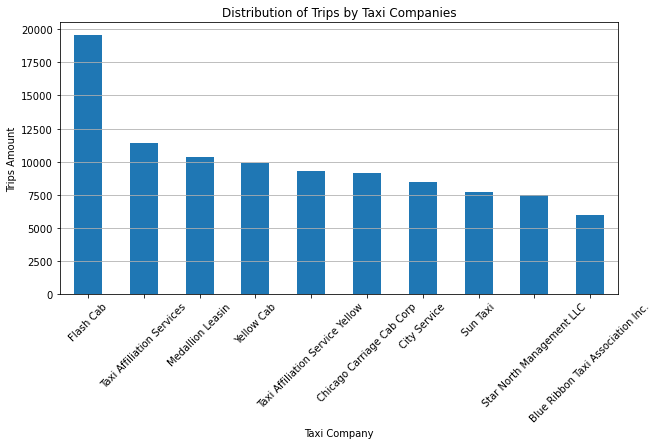

In [12]:
(popular_taxi
     .groupby('company_name')['trips_amount']
     .sum()
     .sort_values(ascending=False)
     .plot(kind='bar', figsize=(10, 5))
)

plt.title('Distribution of Trips by Taxi Companies')
plt.xlabel('Taxi Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylabel('Trips Amount');

In the bar chart, significantly more riders choose Flash Cab than any other companies, nearly 20,000 trips in November alone. The second place is held by Taxi Affiliation Service at half of Flash Cab's amount of rides.

## Hypotheses Testing
<a name="hypo"></a>

### Weather and Duration of Rides

1. Null and Alternative Hypotheses

H0: The null hypothesis states that a population parameter (such as the mean, the standard deviation, and so on) is equal to a hypothesized value. In this case it means that the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays is the same as any other day.

H1: The alternative hypothesis states that a population parameter is smaller, greater, or different than the hypothesized value in the null hypothesis. In this case it means that the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays is different than any other day.

2. Criteria for a decision (alpha value)

In behavioral science, the level of significance is typically set at 5% and we will choose this criteria as well. When the probability of obtaining a sample mean is less than 5% if the null hypothesis were true, then we reject the value stated in the null hypothesis.

3. Calculate the t-test

In order to test our hypothesis that the means of two statistical populations are equal based on samples taken from them, we will apply the method scipy.stats.ttest_ind().

The method takes the following parameters:

- array1, array2 are arrays containing the samples. We will use the total_sales variables that we will calculate for both platforms;
- equal_var is an optional parameter that specifies whether or not the variances of the populations should be considered equal.

### Third Dataframe Information and Processing

In [31]:
data_info(weather_records)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date and time  697 non-null    object
 1   Temperature    697 non-null    object
 2   Description    697 non-null    object
dtypes: object(3)
memory usage: 16.5+ KB
None

First five rows:
         Date and time Temperature       Description
0  2017-11-01 00:00:00     276.150     broken clouds
1  2017-11-01 01:00:00     275.700  scattered clouds
2  2017-11-01 02:00:00     275.610   overcast clouds
3  2017-11-01 03:00:00     275.350     broken clouds
4  2017-11-01 04:00:00     275.240     broken clouds

Description of the dataset:
              Date and time Temperature   Description
count                   697         697           697
unique                  697         496            19
top     2017-11-04 16:00:00     275.960  sky is clear
freq                     

In [14]:
data_info(df_three)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
None

First five rows:
              start_ts weather_conditions  duration_seconds
0  2017-11-25 16:00:00               Good            2410.0
1  2017-11-25 14:00:00               Good            1920.0
2  2017-11-25 12:00:00               Good            1543.0
3  2017-11-04 10:00:00               Good            2512.0
4  2017-11-11 07:00:00               Good            1440.0

Description of the dataset:
       duration_seconds
count       1068.000000
mean        2071.731273
std          769.461125
min            0.000000
25%         1438.250000
50%        

The third dataset tells us about the rides' duration and weather condition . The dataset does not have any missing values, but it has 197 duplicates, some ride duration is 0 and some columns do not have the correct datatype, so we need to process them before we can move forward with analysing the dataset.

In [15]:
df_three = df_three.drop_duplicates()

In [16]:
df_three.loc[df_three['duration_seconds'] == 0] = np.nan

In [17]:
df_three = df_three.dropna(subset=['duration_seconds'], axis=0)
df_three.reset_index(drop=True, inplace=True)

In [18]:
df_three.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [19]:
df_three['start_ts'] = pd.to_datetime(df_three['start_ts'], format='%Y-%m-%d')
df_three['duration_seconds'] = df_three['duration_seconds'].astype(int)

As the analysis is only for Saturdays, we need to make sure that all the data are from rides taken on a Saturday.

In [20]:
df_three['ride_day'] = df_three['start_ts'].dt.dayofweek

array([5])

In [21]:
df_three['ride_day'].value_counts()

5    865
Name: ride_day, dtype: int64

### Good & Bad Weather Rides

In [22]:
good_weather = df_three.query('weather_conditions == "Good"')
bad_weather = df_three.query('weather_conditions == "Bad"')

In [23]:
print('Good Weather Ride Duration Description')
print(good_weather['duration_seconds'].describe())
print()
print('Bad Weather Ride Duration Description')
print(bad_weather['duration_seconds'].describe())

Good Weather Ride Duration Description
count     717.000000
mean     2049.259414
std       753.877274
min        60.000000
25%      1440.000000
50%      1916.000000
75%      2493.000000
max      7440.000000
Name: duration_seconds, dtype: float64

Bad Weather Ride Duration Description
count     148.000000
mean     2409.229730
std       751.544705
min       480.000000
25%      1746.000000
50%      2463.500000
75%      2940.000000
max      4980.000000
Name: duration_seconds, dtype: float64


Based on the description above, the variance of these two parameters look quite different, so we will perform Levene's test to see if they actually do not have equal variance.

In [24]:
st.levene(good_weather['duration_seconds'], bad_weather['duration_seconds'])

LeveneResult(statistic=0.052091482462132625, pvalue=0.8195171648369002)

The p-value suggests that the populations do not have equal variance. Therefore we will set equal_var to False.

In [25]:
alpha = 0.05

results = st.ttest_ind(good_weather['duration_seconds'], bad_weather['duration_seconds'], equal_var=False)

print('p-value:',results.pvalue)
print('Is p-value less than alpha?',results.pvalue < alpha)

if (results.pvalue < alpha):
    print("We reject the null hypotheses. The average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays is different than any other day.")
else:
    print("We retain the null hypotheses. The average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays is the same as any other day.")

p-value: 2.859195727873403e-07
Is p-value less than alpha? True
We reject the null hypotheses. The average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays is different than any other day.


## Overall Conclusions
<a name="cons"></a>

1. In this report, we have analysed three datasets with different parameters for taxi riding behaviour in Chicago in November, such as dropoff location, taxi companies used, weather condition and ride duration.
2. Before going into the analysis, we have prepared the data by checking for any problems, changing the data types, categorising the data and adding relevant information into the dataset.
3. We have found that most riders are heading to the happening areas in Downtown Chicago like The Loop, areas near Lake Michigan, as well as Chicago O'Hare airport.
4. We have also found that Flash Cab dominates all taxi companies based on the amount of rides, at nearly 20,000 rides in a month. They may dominate because of the cheap rate and easy booking.
5. There are 5 rides with 0 seconds duration on the third dataset, which may result because of cancelled bookings or due to an error upon retrieval of the dataset.
6. We have tested the hypotheses that "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays." The result shows that the duration of rides from the Loop to O'Hare International Airport, on average, does not change on rainy Saturdays.